# EP-ABC: Simple example

## Setup

In [1]:
import numpy as np
import scipy.stats as stats

from tqdm import tqdm_notebook

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## Toy Example

In [2]:
data = np.random.binomial(3, 0.3, size=5)
data

array([0, 3, 1, 1, 0])

## MCMC-ABC

Try to find success probability $p$. Let $N = 5$ be fixed. Use mean and standard deviation as sufficient statistics. Use Euclidean norm as distance function. Use $p \sim \mathrm{Beta}(2, 2)$ as a prior. Use $N(p, \sigma^2)$ as transition kernel.

In [3]:
D = np.array([np.mean(data), np.std(data)])
D

array([1.        , 1.09544512])

In [15]:
import sympy as sy
x = sy.Symbol('x')
sy.simplify(sy.diff(sy.log(x / (1 - x)), x))

-1/(x*(x - 1))

Prior

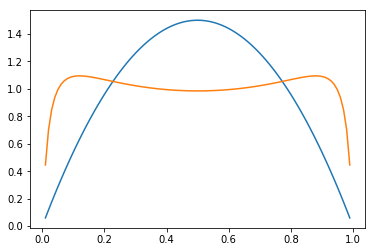

In [47]:
xs = np.arange(0.01, 1., 0.01)
ys = stats.beta(2, 2).pdf(xs)
ys2 = stats.norm(0, 1.62).pdf(np.log(xs / (1. - xs))) / (xs * (1. - xs))
plt.plot(xs, ys);
plt.plot(xs, ys2);

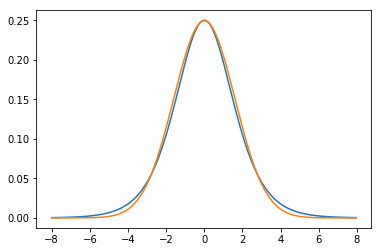

In [50]:
xs = np.arange(-8., 8., 5e-2)
ys = stats.uniform(0., 1.).pdf(1. / (1. + np.exp(-xs))) * \
    1. / (1. + np.exp(-xs)) * (1 - 1. / (1. + np.exp(-xs)))
plt.plot(xs, ys);
plt.plot(xs, stats.norm(0, 1.6).pdf(xs))

If a uniform prior is chosen on $[0, 1]$ then the transformed prior on an unbounded scale is similar to a normal prior with mean zero and standard deviation $1.6$.

### Algorithm

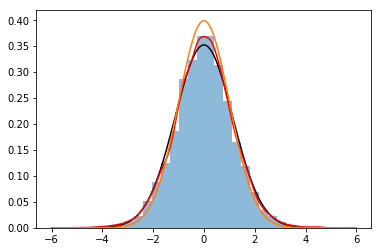

In [51]:
trs = -np.log(1. / stats.beta(2, 2).rvs(10000) - 1)
plt.hist(trs, bins=30, density=True, alpha=0.5);
mu, sigma = stats.norm.fit(trs)
xs = np.arange(-6, 6, 1e-2)
ys = stats.norm(mu, sigma).pdf(xs)
plt.plot(xs, ys, 'k');
plt.plot(xs, stats.gaussian_kde(trs, 'scott')(xs), 'r');
plt.plot(xs, stats.norm.pdf(xs))

In [99]:
mu, sigma

(0.002561802847671616, 1.139387940462467)

Since $p \in [0, 1]$ it might be best to do inference on $\mathrm{logit}(p)$ or $\Phi^{-1}(p)$ to ensure that the parameter is unbounded.

In case of $\theta = \mathrm{logit}(p)$, we get that $p = \mathrm{logistic}(\theta)$ and thus 
$$
p(\theta) = p\left(\mathrm{logistic}(\theta)\right) \cdot 
\frac{\mathrm{d}\,\mathrm{logistic}(\theta)}{\mathrm{d}\,\theta} = 
p\left(\mathrm{logistic}(\theta)\right) \cdot \mathrm{logistic}(\theta) \cdot (1 - \mathrm{logistic}(\theta))
$$

In [53]:
def logistic(theta):
    return 1. / (1. + np.exp(-theta))

def loglogistic(theta):
    return -np.log(1. + np.exp(-theta))

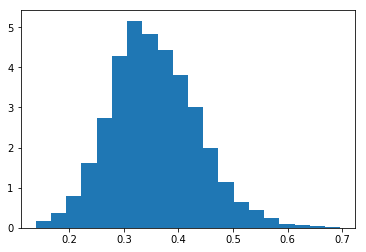

In [39]:
plt.hist(logistic(ps), bins=20, density=True);

In [54]:
M = 10000    # Number of iterations
sigma = 0.1  # Random walk std dev
eps = 1e-1   # ABC epsilon
ps = np.zeros((M + 1,), dtype='float64')

# Transform to unbounded space, prior on unbounded scale
# ps[0] = -np.log(1. / stats.beta(2, 2).rvs() - 1.)
ps[0] = 0.1 * np.random.randn()

for m in range(M):
    if m % 1000 == 0:
        print(m)
    while True:
        pnew = ps[m] + sigma * np.random.randn()

        data_sim = np.random.binomial(3, logistic(pnew), size=5)
        Dsim = np.array([np.mean(data_sim), np.std(data_sim)])

        if np.linalg.norm(D - Dsim) <= eps:
            break
    
#     lacc = stats.beta(2, 2).logpdf(logistic(pnew)) + \
#         loglogistic(pnew) + np.log(1 - logistic(pnew)) - \
#         (stats.beta(2, 2).logpdf(logistic(ps[m])) + \
#         loglogistic(ps[m]) + np.log(1 - logistic(ps[m])))
    lacc = stats.norm(0, 1.6).logpdf(pnew) - stats.norm(0, 1.6).logpdf(ps[m])
    # Metropolis-Hastings acceptance step
    h = min(1, np.exp(lacc))
    if np.random.rand() <= h:
        ps[m + 1] = pnew
    else:
        ps[m + 1] = ps[m]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [55]:
ps_abc = ps

## Comparison to convential MH MCMC

In [56]:
M = 10000    # Number of iterations
sigma = 0.1  # Random walk std dev
ps = np.zeros((M + 1,), dtype='float64')

# Transform to unbounded space
# ps[0] = -np.log(1. / stats.beta(2, 2).rvs() - 1.)
ps[0] = 0.1 * np.random.randn()

for m in range(M):
    if m % 1000 == 0:
        print(m)
        
    pnew = ps[m] + sigma * np.random.randn()
    
#     lacc = np.sum(stats.binom.logpmf(data, 3, logistic(pnew))) + \
#         stats.beta(2, 2).logpdf(logistic(pnew)) + \
#         loglogistic(pnew) + np.log(1 - logistic(pnew)) - \
#         (np.sum(stats.binom.logpmf(data, 3, logistic(ps[m]))) + \
#          stats.beta(2, 2).logpdf(logistic(ps[m])) + \
#          loglogistic(ps[m]) + np.log(1 - logistic(ps[m])))
    lacc = np.sum(stats.binom.logpmf(data, 3, logistic(pnew))) + \
        stats.norm(0, 1.6).logpdf(pnew) - \
        (np.sum(stats.binom.logpmf(data, 3, logistic(ps[m]))) + \
         stats.norm(0, 1.6).logpdf(ps[m]))

    # Metropolis-Hastings acceptance step
    h = min(1, np.exp(lacc))
    if np.random.rand() <= h:
        ps[m + 1] = pnew
    else:
        ps[m + 1] = ps[m]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [57]:
ps_mh = ps

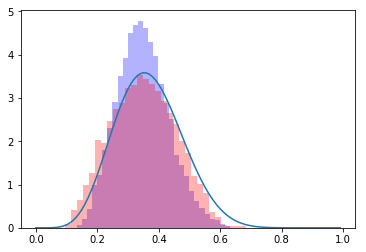

In [58]:
xs = np.arange(0., 1., 1e-2)
ys = stats.beta(2 + np.sum(data), 2 + np.sum(3 - data)).pdf(xs)
plt.plot(xs, ys)

plt.hist(logistic(ps_abc), bins=30, density=True, alpha=0.3, color='b')
plt.hist(logistic(ps_mh), bins=30, density=True, alpha=0.3, color='r');

In [59]:
kde_abc = stats.gaussian_kde(logistic(ps_abc), 'silverman')
kde_mh = stats.gaussian_kde(logistic(ps_mh), 'silverman')

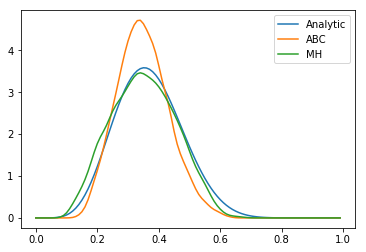

In [61]:
plt.plot(xs, ys)
plt.plot(xs, kde_abc(xs));
plt.plot(xs, kde_mh(xs));
plt.legend(['Analytic', 'ABC', 'MH']);